In [540]:
import math
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import ufloat
from uncertainties import unumpy
from uncertainties.umath import exp, sqrt, log
from scipy import odr
import glob
import os

# Frequency-dependent voltage divider and filter

In [541]:
C = ufloat(100*10**(-9), 5*10**(-10)) # capacity in F
R = ufloat(1*10**(3), 5*10**2) # resistance in Ω

U_in = ufloat(1, 0.5) # adjust in Volts

lowpass_data = np.loadtxt('lowpass.txt', delimiter=',')
f = lowpass_data[:, 0] # frequency in Hz
U_out = lowpass_data[:, 1] # voltage in V
phi_time = lowpass_data[:, 2] * 10**(-3) # phase in s

f = unumpy.uarray(f, np.full_like(f, 1)) # adjust uncertainty
U_out = unumpy.uarray(U_out, np.full_like(U_out, 0.0005)) # adjust uncertainty
phi_rad = unumpy.uarray(phi_time, np.full_like(phi_time, 0.5*10**(-3))) / (1/f) * 2 * math.pi  # adjust uncertainty

U_out_over_U_in = unumpy.nominal_values(U_out/U_in)

log_omega = unumpy.log(f*2*math.pi)

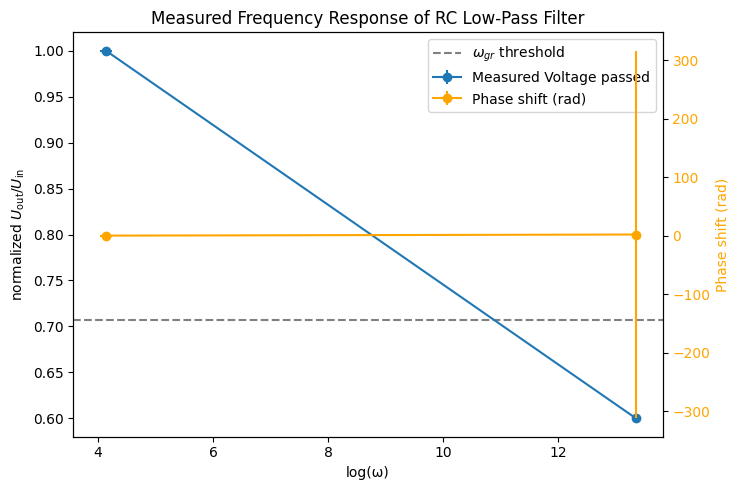

In [542]:
fig, ax1 = plt.subplots(figsize=(7.5, 5))

ax1.errorbar(unumpy.nominal_values(log_omega), unumpy.nominal_values(U_out_over_U_in), yerr=unumpy.std_devs(U_out_over_U_in), xerr=unumpy.std_devs(log_omega), fmt='-o', label='Measured Voltage passed'
)
ax1.set_ylabel(r'normalized $U_\mathrm{out} / U_\mathrm{in}$')
ax1.set_xlabel('log(ω)')
ax1.set_title('Measured Frequency Response of RC Low-Pass Filter')

ax2 = ax1.twinx()
ax2.errorbar(unumpy.nominal_values(log_omega), unumpy.nominal_values(phi_rad), label='Phase shift (rad)', yerr=unumpy.std_devs(phi_rad), xerr=unumpy.std_devs(log_omega), color='orange', fmt='-o')
ax2.set_ylabel('Phase shift (rad)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

ax1.axhline(1 / math.sqrt(2), color='gray', linestyle='--', label=r'$\omega_{gr}$ threshold')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')

plt.tight_layout()
plt.savefig('low_pass.png', dpi=600)
plt.show()

In [543]:
w_gr_mes_log = ufloat(10, 0.5) # adjust in log(ω)
w_gr_mes = exp(w_gr_mes_log)
w_gr_exp = 1/(R*C)

delta_w_gr = 100*(w_gr_exp-w_gr_mes)/w_gr_mes # in %
print(f"ω_gr_mes = {w_gr_mes} Hz")
print(f"ω_gr_exp = {w_gr_exp} Hz")
print(f"delta_ω_gr = {delta_w_gr} %") # how far away the estimate from the measured value is

ω_gr_mes = (2.2+/-1.1)e+04 Hz
ω_gr_exp = (1.0+/-0.5)e+04 Hz
delta_ω_gr = -55+/-32 %


# RLC parallel circuit

In [544]:
L = ufloat(10*10**(-3), 5*10**(-4)) # inductance in Hz
C = ufloat(100*10**(-9), 5*10**(-10)) # capacity in C
R = ufloat(1*10**(3), 5*10**2) # resistance in Ω

U_in = ufloat(1, 0.5) # adjust in V

RLC_parallel = np.loadtxt('RLC_parallel.txt', delimiter=',')
f = RLC_parallel[:, 0] # frequency in Hz
U_out = RLC_parallel[:, 1] # voltage in V
phi_time = RLC_parallel[:, 2] * 10**(-3) # phase in s

f = unumpy.uarray(f, np.full_like(f, 1)) # adjust uncertainty
U_out = unumpy.uarray(U_out, np.full_like(U_out, 0.0005)) # adjust uncertainty
phi_rad = unumpy.uarray(phi_time, np.full_like(phi_time, 0.5*10**(-3))) / (1/f) * 2 * math.pi  # adjust uncertainty

omega = f*2*math.pi

In [545]:
# fit
# makes a rough estimate for parameters of gaussian distributions
def initial_guess(x,y):
    A0 = (np.nanmax(y) - np.nanmin(y)) or 1.0
    mu0 = x[np.nanargmax(y)]
    sigma0 = (np.nanmax(x) - np.nanmin(x)) / 10
    C0 = float(np.nanmin(y))
    return A0, mu0, sigma0, C0

def single_gaussian_model(beta, x):
    A, mu, sigma, C = beta
    return A * np.exp(-((x - mu)**2) / (2 * sigma**2)) + C

def single_gaussian_fit_odr(x, y):
    x_nominal = unumpy.nominal_values(x)
    y_nominal = unumpy.nominal_values(y)
    x_sigma = unumpy.std_devs(x)
    y_sigma = unumpy.std_devs(y)

    p0 = initial_guess(x_nominal, y_nominal)
    data = odr.RealData(x_nominal, y_nominal, sx=x_sigma, sy=y_sigma)
    model = odr.Model(single_gaussian_model)
    odr_obj = odr.ODR(data, model, beta0=p0)
    out = odr_obj.run()
    popt = out.beta
    pcov = out.cov_beta

    A, mu, sigma, C = popt
    A = ufloat(A, pcov[0][0])
    mu = ufloat(mu, pcov[1][1])
    sigma = ufloat(sigma, pcov[2][2])
    C = ufloat(C, pcov[3][3])

    return A, mu, sigma, C

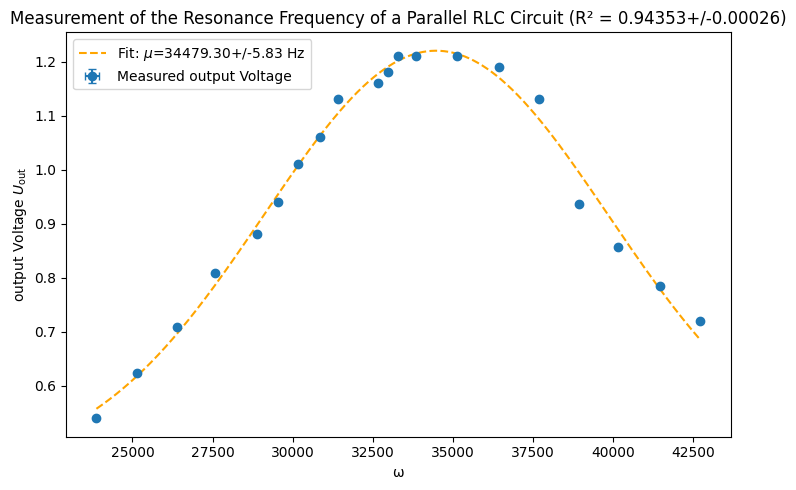

In [546]:
# fit
A, mu, sigma, C = single_gaussian_fit_odr(omega, U_out)
x_fit = np.linspace(np.min(unumpy.nominal_values(omega)), np.max(unumpy.nominal_values(omega)), 1000)
y_fit = single_gaussian_model([A.n, mu.n, sigma.n, C.n], x_fit)

# r2 score
y_r2 = single_gaussian_model([A.n, mu.n, sigma.n, C.n], np.linspace(np.min(unumpy.nominal_values(omega)), np.max(unumpy.nominal_values(omega)), len(omega)))
residuals = U_out - y_r2
ss_res = np.sum(residuals**2)
ss_tot = np.sum((U_out - np.mean(U_out))**2)
r2 = 1.0 - ss_res/ss_tot

plt.figure(figsize=(7.5,5))
plt.errorbar(unumpy.nominal_values(omega), unumpy.nominal_values(U_out), yerr=unumpy.std_devs(U_out), xerr=unumpy.std_devs(omega), fmt='o', capsize=3, label='Measured output Voltage')
plt.plot(x_fit, y_fit, "--", color="orange", label=fr"Fit: $\mu$={mu:.2f} Hz")
plt.ylabel(r'output Voltage $U_\mathrm{out}$')
plt.xlabel('ω')
plt.title(f'Measurement of the Resonance Frequency of a Parallel RLC Circuit (R² = {r2:.5f})')
plt.legend()
plt.tight_layout()
plt.savefig('RLC_parallel_resonance.png', dpi=600)
plt.show()

In [547]:
omega_0 = mu
omega_u = mu - sigma*sqrt(log(2))
omega_o = mu + sigma*sqrt(log(2))
delta_omega = np.abs(omega_u - omega_o)

Q_observed = omega_0/delta_omega
Q_theory = R * sqrt(C/L)
print(f"Q-factor theoretical: {Q_theory:.2f}")
print(f"Q-factor observed: {Q_observed:.2f}")

Q-factor theoretical: 6683.03+/-3345.69
Q-factor observed: 3.85+/-0.05


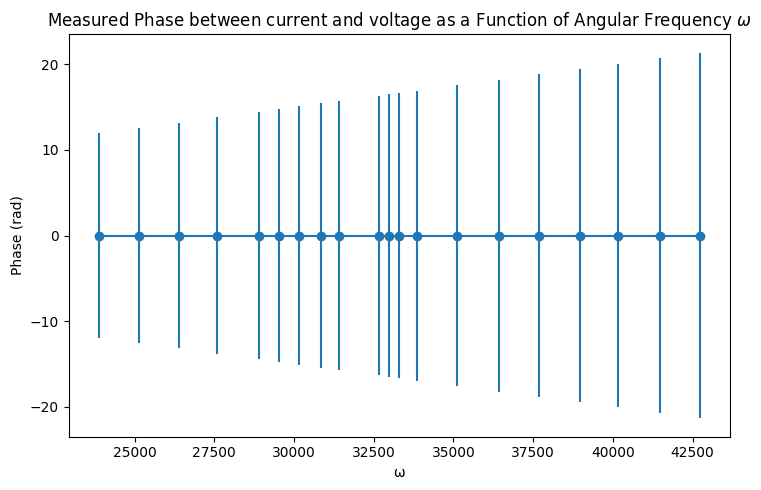

In [548]:
plt.figure(figsize=(7.5,5))

plt.errorbar(unumpy.nominal_values(omega), unumpy.nominal_values(phi_rad), label='Phase shift (rad)', yerr=unumpy.std_devs(phi_rad), xerr=unumpy.std_devs(omega), fmt='-o')
plt.ylabel('Phase (rad)')
plt.xlabel('ω')
plt.title(r'Measured Phase between current and voltage as a Function of Angular Frequency $\omega$')
plt.tight_layout()
plt.savefig('RLC_parallel_phase_shift.png', dpi=600)
plt.show()

In [549]:
def process_file(filename, debug=False):
    data = np.loadtxt(filename, delimiter=',')
    f = data[:, 0]
    U_out = data[:, 1]

    f = unumpy.uarray(f, np.full_like(f, 1.0)) # adjust uncertainty
    U_out = unumpy.uarray(U_out, np.full_like(U_out, 0.0005)) # adjust uncertainty

    omega = f * 2 * math.pi

    A, mu, sigma, C = single_gaussian_fit_odr(omega, U_out)

    omega_0 = mu
    omega_u = mu - sigma * sqrt(log(2))
    omega_o = mu + sigma * sqrt(log(2))
    delta_omega = abs(omega_o - omega_u)

    Q_observed = omega_0 / delta_omega

    # extract C and L from filename
    base = os.path.basename(filename)
    name_trim = os.path.splitext(base)[0]
    c_str, l_str = name_trim.split('-')

    C_val = float(c_str) * 1e-9 # nF to F
    L_val = float(l_str) * 1e-3 # mH to H

    C = ufloat(C_val, 0.5e-9) # adjust uncertainty
    L = ufloat(L_val, 0.5e-3) # adjust uncertainty

    Q_theory = R * sqrt(C / L)

    if debug:
        x_fit = np.linspace(np.min(unumpy.nominal_values(omega)), np.max(unumpy.nominal_values(omega)), 1000)
        y_fit = single_gaussian_model([A.n, mu.n, sigma.n, C.n], x_fit)

        plt.figure(figsize=(7.5,5))
        plt.errorbar(unumpy.nominal_values(omega), unumpy.nominal_values(U_out), yerr=unumpy.std_devs(U_out), xerr=unumpy.std_devs(omega), fmt='o', capsize=3, label='Measured output Voltage')
        plt.plot(x_fit, y_fit, "--", color="orange", label=fr"Fit: $\mu$={mu.n:.2f} rad/s")
        plt.ylabel(r'output Voltage $U_\mathrm{out}$ [V]')
        plt.xlabel(r'$\omega$ [rad/s]')
        plt.title(f'{base}\n' fr'$\omega_0$ = {mu.n:.2f} rad/s, 'fr'$Q_{{obs}}$ = {Q_observed.n:.2f}')
        plt.legend()
        plt.tight_layout()
        plt.show()

    return {"file": base, "omega_0": omega_0, "Q_observed": Q_observed, "Q_theory": Q_theory}


results = []
for file in sorted(glob.glob("RLC_resonance/*.txt")):
    results.append(process_file(file))


print("\nSummary of resonance results:")
for r in results:
    print(f"{r['file']:<12}  " f"ω0 = {r['omega_0']:.2f}  " f"Q_obs = {r['Q_observed']:.2f}  " f"Q_theo = {r['Q_theory']:.2f}")


Summary of resonance results:
10-1.txt      ω0 = 34479.30+/-5.83  Q_obs = 3.85+/-0.05  Q_theo = 3.16+/-1.77
10-10.txt     ω0 = 34479.30+/-5.83  Q_obs = 3.85+/-0.05  Q_theo = 1.00+/-0.50
100-1.txt     ω0 = 34479.30+/-5.83  Q_obs = 3.85+/-0.05  Q_theo = 10.00+/-5.59
100-10.txt    ω0 = 34479.30+/-5.83  Q_obs = 3.85+/-0.05  Q_theo = 3.16+/-1.58
1000-1.txt    ω0 = 34479.30+/-5.83  Q_obs = 3.85+/-0.05  Q_theo = 31.62+/-17.68
1000-10.txt   ω0 = 34479.30+/-5.83  Q_obs = 3.85+/-0.05  Q_theo = 10.00+/-5.01
